In [1]:
import os
import numpy as np
import torch.backends.cudnn as cudnn
import torch
from torchvision import models
from torch import nn
from torch.utils.tensorboard import SummaryWriter
import torch.autograd as autograd
from models import Generator, Discriminator
from xxydataset import xxyDataset
import utils
import xlwt
import xlrd
from xlutils.copy import copy
import time
import IPython.display as display
import matplotlib.pyplot as plt
# import imageio
# from PIL import Image

In [2]:
# if os.path.exists('./log_wgan-gp.xls'):
#         os.remove('./log_wgan-gp.xls')
# wb = xlwt.Workbook()
# ws = wb.add_sheet('sheet0')
# ws.write(0, 0, 'epoch')
# ws.write(0, 1, 'MSE损失')
# ws.write(0, 2, '生成器损失')
# ws.write(0, 3, '判别器损失')
# ws.write(0, 4, '用时（s）')
# wb.save('./log_wgan-gp.xls')

In [3]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.cuda.FloatTensor(np.random.random((real_samples.size(0), 1, 1, 1)))
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    fake = autograd.Variable(torch.cuda.FloatTensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
torch.cuda.set_device(0)
global checkpoint, start_epoch
# 生成器模型参数
kernel_size_g = 3         # 中间层卷积的核大小
n_channels_g = 64         # 中间层通道数
n_blocks_g = 5            # 残差模块数量

# 判别器模型参数
kernel_size_d = 3  # 所有卷积模块的核大小
n_channels_d = 64  # 模块的通道数

# 学习参数
batch_size = 128     # 批大小
start_epoch = 1     # 迭代起始位置
epochs = 5000         # 迭代轮数
checkpoint = None #"./result_wgan-gp/checkpoint_epoch1680.pth"
workers = 1         # 加载数据线程数量
lr = 1e-4           # 学习率   动态调整学习率
lr_adj_1 = 0.1        # 学习率调整乘子
lr_adj_2 = 0.5        # 学习率调整乘子
clip_value = 0.01   # 截断值
lamda_gp = 10       # GP乘子
g_adversarial_ratio = 1 # 对抗损失乘子
tv_loss_ratio = 0#0.66666       # TV损失乘子
mse_loss_ratio = 0#0.166666      # MSE损失乘子
vgg_loss_ratio = 0#0.166666      # VGG损失乘子
    
# 设备参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cudnn.benchmark = True    # 对卷积进行加速

In [5]:
# 模型初始化
generator = Generator(kernel_size=kernel_size_g,
                      n_channels=n_channels_g,
                      n_blocks=n_blocks_g)
discriminator = Discriminator(kernel_size=kernel_size_d,
                              n_channels=n_channels_d)
vgg_16 = models.vgg16(pretrained=True).features

optimizer_g = torch.optim.Adam(params=filter(lambda p: p.requires_grad, generator.parameters()), lr=lr)
optimizer_d = torch.optim.Adam(params=filter(lambda p: p.requires_grad, discriminator.parameters()), lr=lr)

# 损失函数
tv_loss_criterion = utils.TVLoss()
mse_loss_criterion = nn.MSELoss()
adversarial_loss_criterion = nn.BCEWithLogitsLoss()
g_adversarial_loss_criterion = nn.BCEWithLogitsLoss()  # Generator
d_adversarial_loss_criterion = nn.BCEWithLogitsLoss()   # Discriminator

# 将数据移至默认设备
generator = generator.to(device)
discriminator = discriminator.to(device)
vgg_16 = vgg_16.to(device)
mse_loss_criterion = mse_loss_criterion.to(device)
tv_loss_criterion = tv_loss_criterion.to(device)
adversarial_loss_criterion = adversarial_loss_criterion.to(device)
g_adversarial_loss_criterion = g_adversarial_loss_criterion.to(device)
d_adversarial_loss_criterion = d_adversarial_loss_criterion.to(device)

if checkpoint is not None:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    generator.load_state_dict(checkpoint['generator'])
    discriminator.load_state_dict(checkpoint['discriminator'])
    optimizer_g.load_state_dict(checkpoint['optimizer_g'])
    optimizer_d.load_state_dict(checkpoint['optimizer_d'])

train_dataset = xxyDataset()
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=workers,
                                           pin_memory=True)
# n_batch = len(train_loader)

dataset loaded : 30082*1*40*40


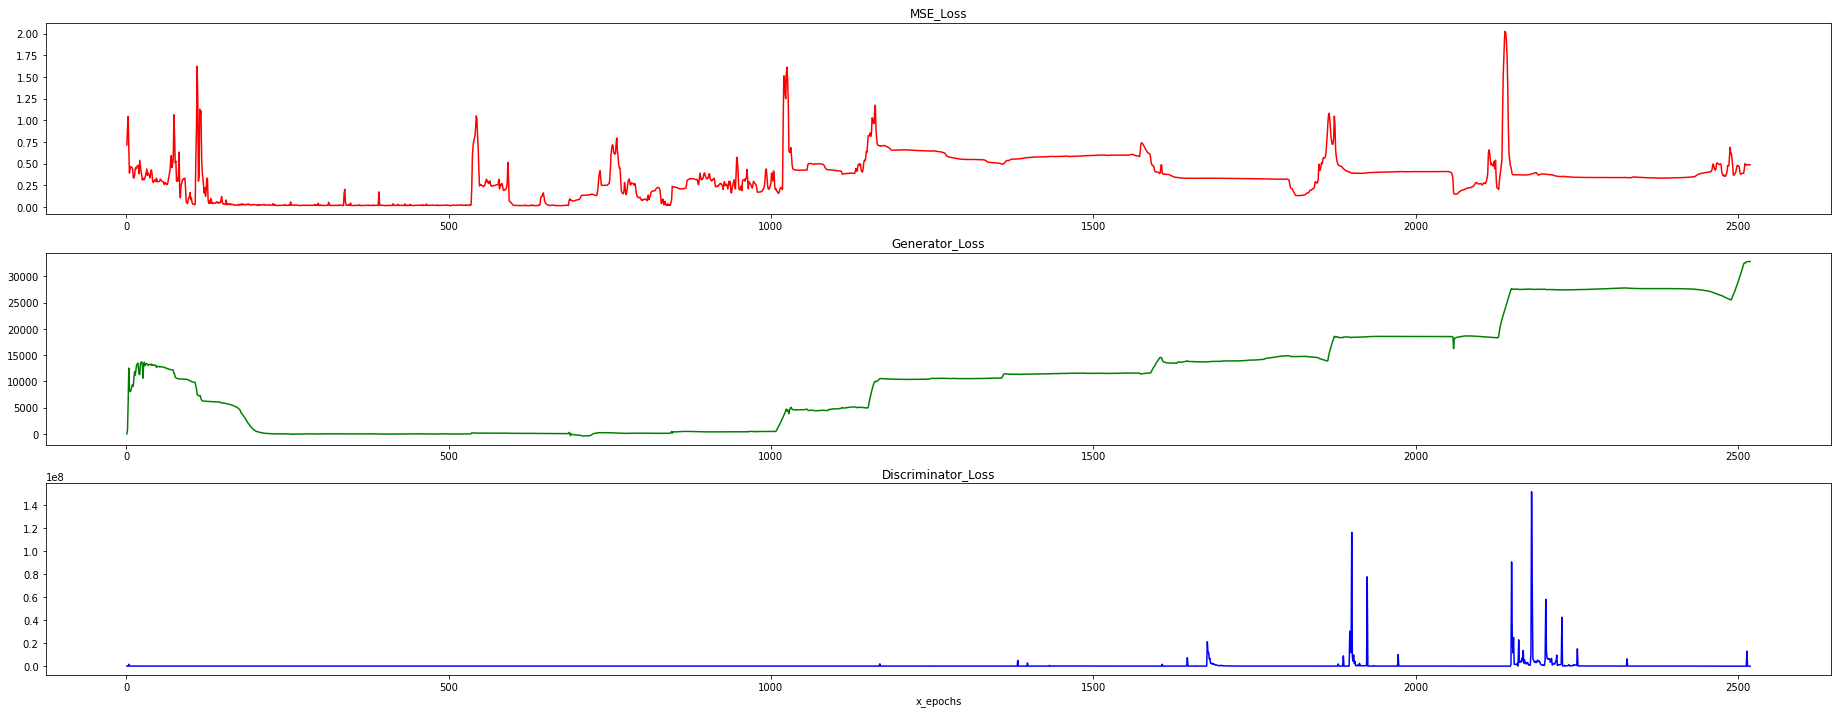

目前最好结果 ：第 633 个epoch   Best_MSE = 0.015329635124679584
第 2520 个epoch结束总用时  20.099 秒 average mse = 0.4820875539423644
第 2521 个epoch结束总用时  20.790 秒 average mse = 0.47708447959644823
第 2522 个epoch结束总用时  21.000 秒 average mse = 0.4713264548467849
第 2523 个epoch结束总用时  20.033 秒 average mse = 0.464094275436648
第 2524 个epoch结束总用时  20.980 秒 average mse = 0.46253500378307816


In [ ]:
# 开始逐轮训练
standard_MSE = 0.0196
best_MSE = 0.0196
best_epoch = -1
print("***开始训练***")
for epoch in range(start_epoch, epochs+1):
    if epoch == 500:  # 降低学习率
        utils.adjust_learning_rate(optimizer_g, lr_adj_1)
        utils.adjust_learning_rate(optimizer_d, lr_adj_1)
    if epoch == 1200:  # 降低学习率
        utils.adjust_learning_rate(optimizer_g, lr_adj_2)
        utils.adjust_learning_rate(optimizer_d, lr_adj_2)
    generator.train()   # 开启训练模式：允许使用批样本归一化
    discriminator.train()
    vgg_16.eval()
    
    losses_c = utils.AverageMeter()  # 内容损失
    losses_a = utils.AverageMeter()  # 生成损失
    losses_d = utils.AverageMeter()  # 判别损失

    start_time = time.time()
    for batch, (lr_imgs, hr_imgs, _, __) in enumerate(train_loader):
        lr_imgs = lr_imgs.type(torch.FloatTensor).to(device)
        hr_imgs = hr_imgs.type(torch.FloatTensor).to(device)
            
        # -----------------------1. 生成器更新----------------------------
        sr_imgs = generator(lr_imgs)
        sr_discriminated = discriminator(sr_imgs)
        
        sr_imgs_vgg = torch.cat([sr_imgs,sr_imgs,sr_imgs],1)
        hr_imgs_vgg = torch.cat([hr_imgs,hr_imgs,hr_imgs],1)
        
        vgg_loss = mse_loss_criterion(vgg_16(sr_imgs_vgg),vgg_16(hr_imgs_vgg))
        tv_loss = tv_loss_criterion(sr_imgs)
        mse_loss = mse_loss_criterion(sr_imgs, hr_imgs)
        g_adversarial_loss = -torch.mean(sr_discriminated)# 生成器希望生成的图像能够完全迷惑判别器，因此它的预期所有图片真值为1
        g_loss = g_adversarial_ratio*g_adversarial_loss + tv_loss_ratio*tv_loss + mse_loss_ratio*mse_loss + vgg_loss_ratio*vgg_loss

        # 后向传播
        optimizer_g.zero_grad()
        g_loss.backward()

        # 更新生成器参数
        optimizer_g.step()

        # 记录损失值
        losses_c.update(mse_loss.item(), lr_imgs.size(0))
        losses_a.update(g_loss.item(), lr_imgs.size(0))

        # -----------------------2. 判别器更新----------------------------
        # 判别器判断
        hr_discriminated = discriminator(hr_imgs)
        sr_discriminated = discriminator(sr_imgs.detach())
        gradient_penalty = compute_gradient_penalty(discriminator, hr_imgs.data, sr_imgs.data)
        
        d_loss = -torch.mean(hr_discriminated) + torch.mean(sr_discriminated) + lamda_gp * gradient_penalty
        
        # 后向传播
        optimizer_d.zero_grad()
        d_loss.backward()

        # 更新判别器
        optimizer_d.step()

        # 记录损失
        losses_d.update(d_loss.item(), hr_imgs.size(0))
    end_time = time.time()

    # 保存预训练模型
    if losses_c.avg < standard_MSE:
        save_path = './result_wgan-gp/checkpoint_epoch' + str(epoch).zfill(4) + '.pth'
        if os.path.exists(save_path):
            os.remove(save_path)
        if losses_c.avg < best_MSE:
            best_epoch = epoch
            best_MSE = losses_c.avg
        save_path = './result_wgan-gp/best_checkpoint_epoch' + str(epoch).zfill(4) + '.pth'
        torch.save({
            'epoch': epoch,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_g': optimizer_g.state_dict(),
            'optimizer_d': optimizer_d.state_dict(),
        }, save_path)

    if epoch % 20 == 0:
        save_path = './result_wgan-gp/checkpoint_epoch' + str(epoch).zfill(4) + '.pth'
        torch.save({
            'epoch': epoch,
            'generator': generator.state_dict(),
            'discriminator': discriminator.state_dict(),
            'optimizer_g': optimizer_g.state_dict(),
            'optimizer_d': optimizer_d.state_dict(),
        }, save_path)
        # 清空单元格输出
        display.clear_output(wait=True)
        
        # 各项损失随epoch的收敛曲线
        rb = xlrd.open_workbook(r'./log_wgan-gp.xls')
        ws = rb.sheet_by_index(0)
        x_epochs  = [float(ws.cell_value(i, 0)) for i in range(1, epoch)]
        mse       = [float(ws.cell_value(i, 1)) for i in range(1, epoch)]
        loss_a    = [float(ws.cell_value(i, 2)) for i in range(1, epoch)]
        loss_d    = [float(ws.cell_value(i, 3)) for i in range(1, epoch)]
        
        plt.figure(figsize=(32, 12))
        plt.subplot(3,1,1)
        plt.title("MSE_Loss")
        plt.plot(x_epochs, mse   , color = 'r',label="mse")
        plt.subplot(3,1,2)
        plt.title("Generator_Loss")
        plt.plot(x_epochs, loss_a, color = 'g',label="loss_generator")
        plt.subplot(3,1,3)
        plt.title("Discriminator_Loss")
        plt.plot(x_epochs, loss_d, color = 'b',label="loss_discriminator")
        plt.xlabel("x_epochs")
        #plt.legend(loc = "best")
        plt.show()
        print("目前最好结果 ：第 " + str(best_epoch) + " 个epoch"  + '   Best_MSE = ' + str(best_MSE))
    print("第 " + str(epoch) + " 个epoch结束" + '总用时  {:.3f} 秒'.format(end_time-start_time) + ' average mse = ' + str(losses_c.avg))
    # 内容损失 losses_c
    # 生成损失 losses_a
    # 判别损失 losses_d
    time_cost = format(end_time-start_time)  # 计算用时
    rb = xlrd.open_workbook(r'./log_wgan-gp.xls')
    wb = copy(rb)
    ws = wb.get_sheet(0)
    ws.write(epoch, 0, epoch)
    ws.write(epoch, 1, losses_c.avg)
    ws.write(epoch, 2, losses_a.avg)
    ws.write(epoch, 3, losses_d.avg)
    ws.write(epoch, 4, time_cost)
    wb.save('./log_wgan-gp.xls')
    # 训练结束关闭监控
print("第 " + str(best_epoch) + " 个epoch"  + '   Best_MSE = ' + str(best_MSE))
# -